In [1]:
import numpy as np
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset
import torch.nn as nn
import matplotlib.pyplot as plt

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using {} device".format(device))

Using cuda device


In [3]:
class CustomImageDataset(Dataset):
    def __init__(self, color, gray, transform=None, target_transform=None):
        self.color = color
        self.gray = gray
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.color)

    def __getitem__(self, idx):
        image = self.gray[idx]
        label = self.color[idx]
        return image, label

In [4]:
transform_gray = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Grayscale(num_output_channels=1),
        transforms.Normalize((0.5), 0.5)
     ])
mean_color = np.array([0.5, 0.5, 0.5])
std_color = np.array([.5, .5 ,.5])
transform_color = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize(mean_color, std_color)
     ])

trainset_gray = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform_gray)
trainset_color = torchvision.datasets.CIFAR10(root='./data', train=True, 
                                              download=True, transform=transform_color)

testset_gray = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform_gray)
testset_color = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform_color)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


In [5]:
color = [sample[0] for sample in trainset_color]
gray = [sample[0] for sample in trainset_gray]

color_test = [sample[0] for sample in testset_color]
gray_test = [sample[0] for sample in testset_gray]

trainset = CustomImageDataset(color, gray)
testset = CustomImageDataset(color_test, gray_test)

In [6]:
color_tensor = torch.stack(color)
gray_tensor = torch.stack(gray)

for t, c in zip([color_tensor, gray_tensor], ["color", "gray"]):
    print(f"{c} props:")
    print(f"Shape: {t.shape}")
    print(f"Mean: {t.mean(axis=[0, 2, 3])}")
    print(f"Std: {t.std(axis=[0, 2, 3])}")

color props:
Shape: torch.Size([50000, 3, 32, 32])
Mean: tensor([-0.0172, -0.0357, -0.1069])
Std: tensor([0.4941, 0.4870, 0.5232])
gray props:
Shape: torch.Size([50000, 1, 32, 32])
Mean: tensor([-0.0384])
Std: tensor([0.4783])


In [7]:
trainset[0][0].shape, trainset[0][1].shape

(torch.Size([1, 32, 32]), torch.Size([3, 32, 32]))

In [8]:
batch_size = 32
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False)

In [9]:
trainloader_gray_class = torch.utils.data.DataLoader(trainset_gray, batch_size=batch_size,
                                          shuffle=True)

testloader_gray_class = torch.utils.data.DataLoader(testset_gray, batch_size=batch_size, shuffle=False)

In [10]:
gray_img_batch, color_img_batch = next(iter(trainloader))
gray_img_batch.shape

torch.Size([32, 1, 32, 32])

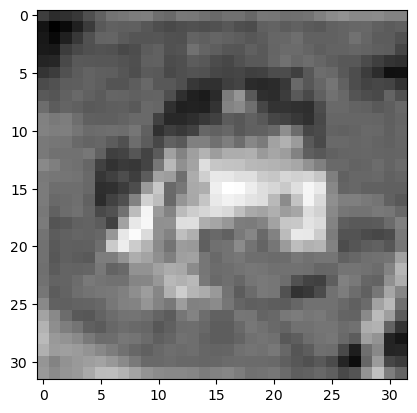

In [11]:
plt.imshow(trainset[0][0].permute(1, 2, 0), cmap='gray')

In [12]:
trainset[0][0].shape

torch.Size([1, 32, 32])

In [13]:
class Colorizer(nn.Module):
    def __init__(self):
        super(Colorizer, self).__init__()
        
        self.conv1 = nn.Conv2d(1, 128, 3, stride=1, padding=1)
        self.norm1 = nn.BatchNorm2d(128)
        self.conv2 = nn.Conv2d(128, 128, 3, stride=1, padding=1)
        self.norm2 = nn.BatchNorm2d(128)
        self.conv3 = nn.Conv2d(128, 3, 1, stride=1, padding=0)
        self.relu = nn.ReLU()
        self.tanh = nn.Tanh()
        
    def forward(self, x):
        x = self.norm1(self.relu(self.conv1(x)))
        x = self.norm2(self.relu(self.conv2(x)))
        x = self.tanh(self.conv3(x))
        return x
    
    
class CIFAR_classifier(nn.Module):
    def __init__(self):
        super(CIFAR_classifier, self).__init__()
        
        self.conv1 = nn.Conv2d(1, 32, 3, stride=1, padding=1)
        self.norm1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 128, 3, stride=1, padding=1)
        self.norm2 = nn.BatchNorm2d(128)
        self.conv3 = nn.Conv2d(128, 10, 1, stride=1, padding=0)
        self.norm3 = nn.BatchNorm2d(10)
        self.global_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=1)
        
    def forward(self, x):
        x = self.norm1(self.relu(self.conv1(x)))
        x = self.norm2(self.relu(self.conv2(x)))
        x = self.norm3(self.relu(self.conv3(x)))
        x = self.global_pool(x).squeeze().squeeze()
        return x
        
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [14]:
model = CIFAR_classifier().to(device)
optim = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.CrossEntropyLoss()

epoch_train_losses = []
epoch_val_losses= []

#Train and eval loop
epochs = 10
for epoch in range(epochs):
    train_losses = []
    for i, (x, y) in enumerate(trainloader_gray_class):
        x = x.to(device)
        y = y.to(device)
        # Forward pass
        y_pred = model(x)
        train_loss = loss_fn(y_pred, y)
        # Backward pass
        optim.zero_grad()
        train_loss.backward()
        optim.step()
        train_losses.append(train_loss.item())
    epoch_train_losses.append(np.mean(train_losses))
    
    #eval
    val_losses = []
    with torch.no_grad():
        for j, (x, y) in enumerate(testloader_gray_class):
            x = x.to(device)
            y = y.to(device)
            y_pred = model(x)
            
            val_loss = loss_fn(y_pred, y)
            val_losses.append(val_loss.item())
    epoch_val_losses.append(np.mean(val_losses))
    print(f'Epoch {epoch+1}/{epochs}, Train Loss: {epoch_train_losses[-1]:.4f}, Eval Loss: {epoch_val_losses[-1]:.4f}', end="\r")
        

In [15]:
#eval and classification report
from sklearn.metrics import classification_report
with torch.no_grad():
    ys = []
    y_preds = []
    for data in testloader_gray_class:
        X, y = data
        X = X.to(device)
        y = y.numpy()
        y_pred = torch.functional.F.softmax(model(X), dim=1)
        y_pred = torch.argmax(y_pred, dim=1).cpu().numpy()
        ys.append(y)
        y_preds.append(y_pred)
    ys = np.concatenate(ys)
    y_preds = np.concatenate(y_preds)
    print(classification_report(ys, y_preds))

              precision    recall  f1-score   support

           0       0.63      0.63      0.63      1000
           1       0.79      0.74      0.76      1000
           2       0.45      0.45      0.45      1000
           3       0.47      0.34      0.39      1000
           4       0.52      0.55      0.53      1000
           5       0.57      0.56      0.57      1000
           6       0.62      0.71      0.66      1000
           7       0.65      0.67      0.66      1000
           8       0.71      0.75      0.73      1000
           9       0.74      0.80      0.77      1000

    accuracy                           0.62     10000
   macro avg       0.62      0.62      0.62     10000
weighted avg       0.62      0.62      0.62     10000



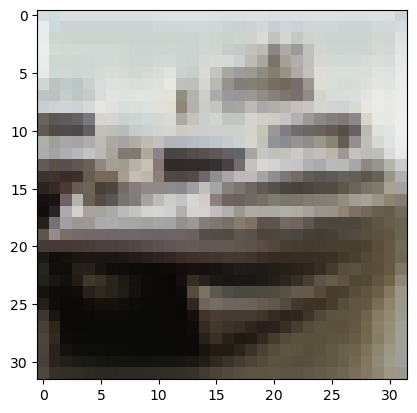

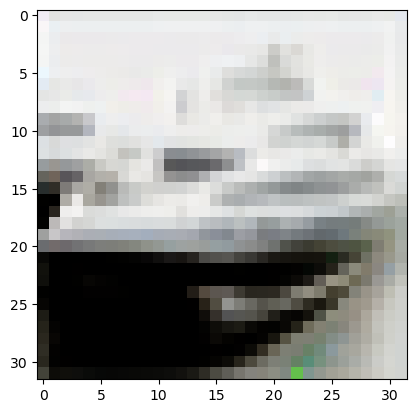

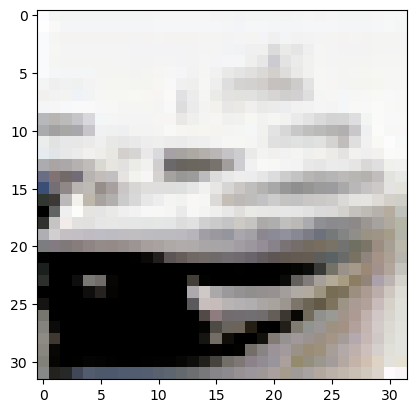

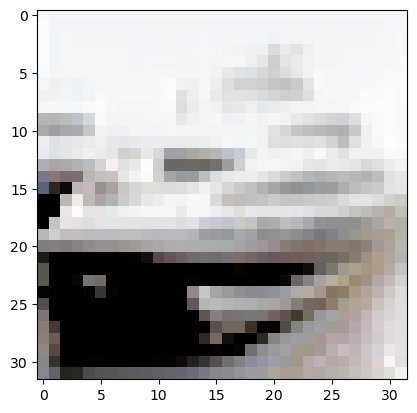

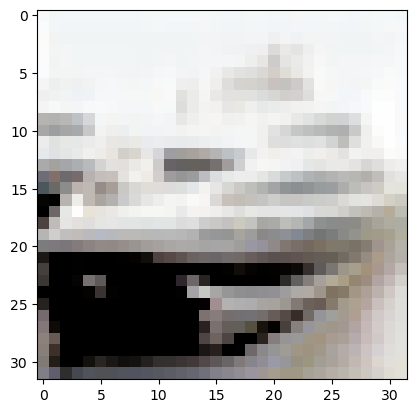

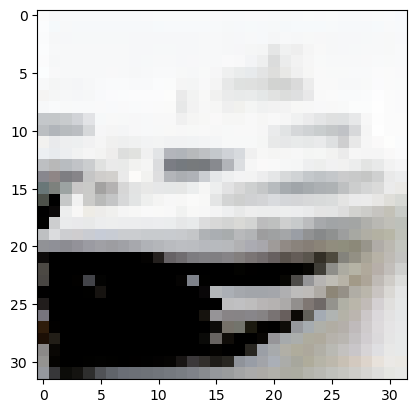

In [16]:
model = Colorizer().to(device)
optim = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.L1Loss()

epoch_train_losses = []
epoch_val_losses= []

test_image = testset[1][0].unsqueeze(0).to(device)

#Train and eval loop
epochs = 30
for epoch in range(epochs):
    train_losses = []
    for i, (x, y) in enumerate(trainloader):
        x = x.to(device)
        y = y.to(device)
        # Forward pass
        y_pred = model(x)
        train_loss = loss_fn(y_pred, y)
        # Backward pass
        optim.zero_grad()
        train_loss.backward()
        optim.step()
        train_losses.append(train_loss.item())
    epoch_train_losses.append(np.mean(train_losses))
    
    #eval
    val_losses = []
    with torch.no_grad():
        for j, (x, y) in enumerate(testloader):
            x = x.to(device)
            y = y.to(device)
            y_pred = model(x)
            val_loss = loss_fn(y_pred, y)
            val_losses.append(val_loss.item())
        if epoch % 5 == 0:
            plt.imshow(np.transpose(model(test_image).squeeze(0).cpu().numpy(), (1,2,0))/2 + 0.5)
            plt.show()
    epoch_val_losses.append(np.mean(val_losses))
    print(f'Epoch {epoch+1}/{epochs}, Train Loss: {epoch_train_losses[-1]:.4f}, Eval Loss: {epoch_val_losses[-1]:.4f}', end="\r")
    

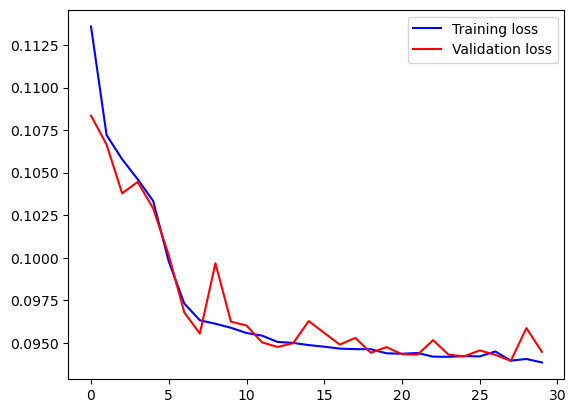

In [17]:
#plot train and test loss
plt.plot(epoch_train_losses, label='Training loss', c='b')
plt.plot(epoch_val_losses, label='Validation loss', c='r')
plt.legend()
plt.show()

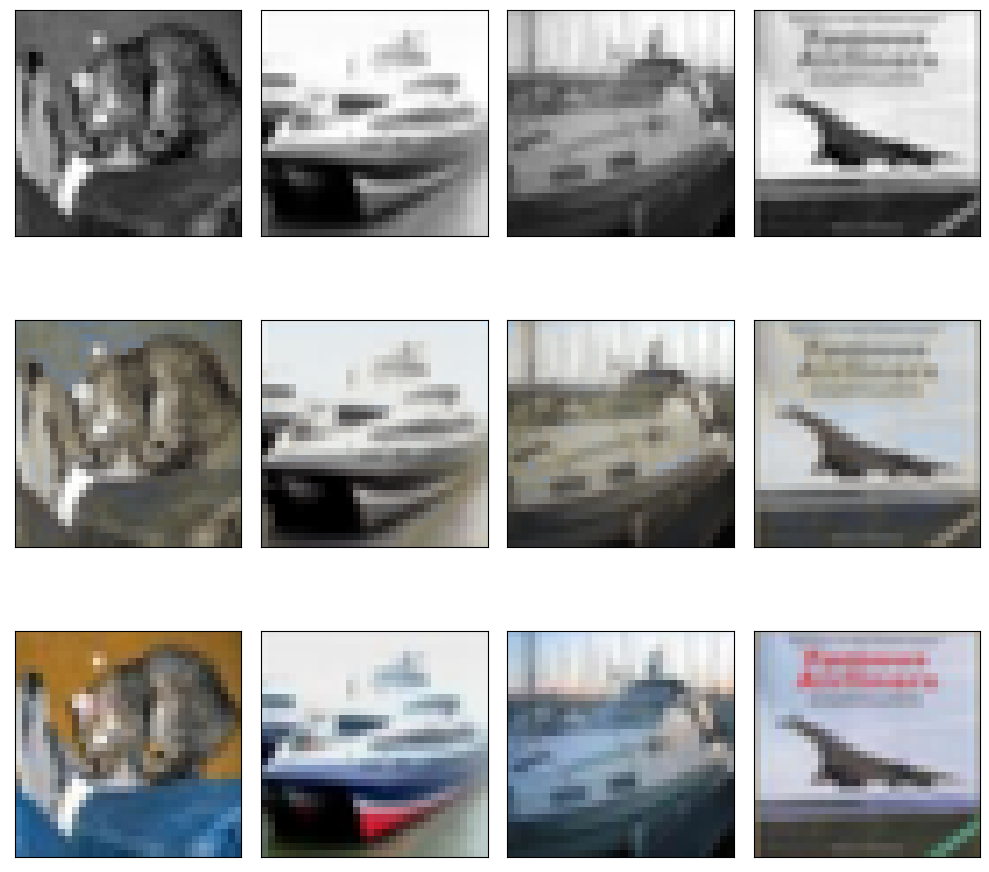

In [19]:
with torch.no_grad():
    for i, (images, labels) in enumerate(testloader):
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        #plot colorized images
        if i == 0:
            fig, axes = plt.subplots(3, 4, figsize=(10,10))
            for j in range(4):
                input = np.transpose(images[j].cpu().numpy(), (1,2,0))/2 + 0.5
                output = np.transpose(outputs[j].cpu().numpy(), (1,2,0))/2 + 0.5 
                label = np.transpose(labels[j].cpu().numpy(), (1,2,0))/2 + 0.5
                
                axes[0,j].imshow(input, cmap='gray')
                axes[1,j].imshow(output)
                axes[2,j].imshow(label)
            plt.setp(axes, xticks=[], yticks=[])
            plt.tight_layout()
            plt.show()